In [1]:
import os
import sys
sys.path.append(os.path.abspath('..'))

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import modules.rcnn.net as net
import modules.rcnn.shapes as shapes
import modules.rcnn.box as box

import matplotlib.patches as patches

In [2]:
H = 40
W = 40
h = H-1
w = W-1

n_min = 2
n_max = 5

x, shap = shapes.get_random_shapes(n_min,n_max,H,W)

gt_box, gt_label = shapes.shapes_to_gt(shap)
print(gt_box)
print(gt_label)

[[0.76073149 0.83333333 0.15666667 0.15666667]
 [0.63057578 0.5        0.26910283 0.26910283]
 [0.41736202 0.16666667 0.18926797 0.26769736]]
[2. 2. 0.]


In [3]:
anchor_boxes = np.array([
    [0.3,0.3],
    [0.2,0.2],
    [0.1,0.1],
    [0.05,0.05],
])

K = anchor_boxes.shape[0]

anchors = np.zeros((H,W,K,4))

for i in range(H):
    for j in range(W):
        anchors[i,j,:,0] = j/(W-1)
        anchors[i,j,:,1] = i/(H-1)
        anchors[i,j,:,2] = anchor_boxes[:,0]
        anchors[i,j,:,3] = anchor_boxes[:,1]
        
anchors_1d = anchors.reshape((-1,4))

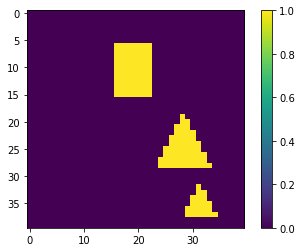

In [4]:
plt.figure()
plt.imshow(x)
plt.colorbar()
plt.show()

In [5]:
Ntrain     = 1000
lr         = 0.001
print_step = 100

In [6]:
x_tf       = tf.placeholder(shape=[1,H,W,1], dtype=tf.float32)
y_box_tf   = tf.placeholder(shape=[H*W*K,4], dtype=tf.float32)
y_label_tf = tf.placeholder(shape=[H*W*K], dtype=tf.float32)
y_weights_tf = tf.placeholder(shape=[H*W*K], dtype=tf.float32)

backbone = net.Backbone(input_channels=1, output_size=32)
rpn      = net.RPN(backbone, num_boxes=K, backbone_channels=32, 
                   window_size=20, hidden_size=64)

rcnn     = net.RCNN(backbone, rpn, anchors, backbone_channels=1, 
                   window_size=10, hidden_size=64, num_classes=3, obj_threshold=0.9, scope='rcnn')


crop_conv, sel_real_box = rcnn(x_tf)

rpn_obj_logits, rpn_obj, rpn_box = rpn(x_tf)

list_box        = tf.reshape(rpn_box, shape=[-1,4])
list_obj_logits = tf.reshape(rpn_obj_logits, shape=[-1])
list_obj        = tf.reshape(rpn_obj, shape=[-1])

loss_class = tf.reduce_sum(y_weights_tf*tf.nn.sigmoid_cross_entropy_with_logits(labels=y_label_tf, 
                                         logits=list_obj_logits))

loss_box   = 10*tf.reduce_sum(y_weights_tf*y_label_tf*(tf.reduce_sum(tf.square(list_box - y_box_tf), axis=1)))

lab_sum = tf.reduce_sum(y_label_tf)

loss = loss_class+loss_box

print(loss_class, loss_box, loss)

W0820 07:54:27.829398 139690303584064 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0820 07:54:27.830695 139690303584064 deprecation_wrapper.py:119] From /home/gabriel/projects/centerline_detection/modules/rcnn/net.py:14: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0820 07:54:27.831570 139690303584064 deprecation_wrapper.py:119] From /home/gabriel/projects/centerline_detection/modules/layers_new.py:35: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0820 07:54:27.971700 139690303584064 deprecation.py:323] From /home/gabriel/anaconda3/lib/python3.7/site-packages/tensorflow/py

Tensor("Sum_1:0", shape=(), dtype=float32) Tensor("mul_7:0", shape=(), dtype=float32) Tensor("add_2:0", shape=(), dtype=float32)


In [7]:
opt = tf.train.AdamOptimizer(lr)
train_op = opt.minimize(loss)

In [8]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [9]:
for i in range(Ntrain):
    
    x, shap = shapes.get_random_shapes(n_min,n_max,H,W)
    
    gt_box, gt_label = shapes.shapes_to_gt(shap)
    
    gt_t, gt_matched, gt_labels, gt_weights =\
    box.create_box_gt(anchors_1d, gt_box)
    
    x = x.reshape((1,H,W,1))
    
    sess.run(train_op, {x_tf:x, y_box_tf:gt_t, y_label_tf:gt_labels, y_weights_tf:gt_weights})
    
    if i%print_step == 0:
        l,lc,lb,ls = sess.run([loss, loss_class, loss_box, lab_sum], {x_tf:x, y_box_tf:gt_t, y_label_tf:gt_labels, y_weights_tf:gt_weights})
        
        print("iteration {}: loss={:.3f} loss_class={:.3f} loss_box={:.3f}, lab_sum={:.1f}".format(i,l, lc, lb, ls))

iteration 0: loss=4238.814 loss_class=4230.534 loss_box=8.280, lab_sum=14.0
iteration 100: loss=14.128 loss_class=13.065 loss_box=1.063, lab_sum=2.0
iteration 200: loss=11.533 loss_class=6.486 loss_box=5.048, lab_sum=8.0
iteration 300: loss=6.007 loss_class=3.362 loss_box=2.645, lab_sum=17.0
iteration 400: loss=17.812 loss_class=17.284 loss_box=0.528, lab_sum=2.0
iteration 500: loss=4.195 loss_class=2.306 loss_box=1.889, lab_sum=17.0
iteration 600: loss=1.569 loss_class=0.722 loss_box=0.847, lab_sum=7.0
iteration 700: loss=7.573 loss_class=2.032 loss_box=5.541, lab_sum=17.0
iteration 800: loss=4.199 loss_class=2.599 loss_box=1.600, lab_sum=7.0
iteration 900: loss=3.531 loss_class=0.656 loss_box=2.875, lab_sum=28.0


In [10]:
x, shap = shapes.get_random_shapes(n_min,n_max,H,W)

gt_box, gt_label = shapes.shapes_to_gt(shap)

gt_t, gt_matched, gt_labels, gt_weights =\
box.create_box_gt(anchors_1d, gt_box)

x = x.reshape((1,H,W,1))

out_box, l_box, out_obj = sess.run([rpn_box, list_box, rpn_obj], {x_tf:x})

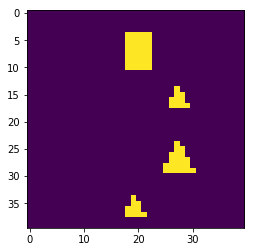

0


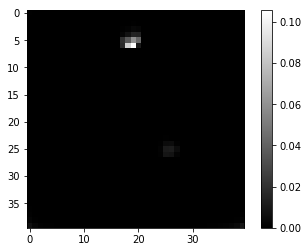

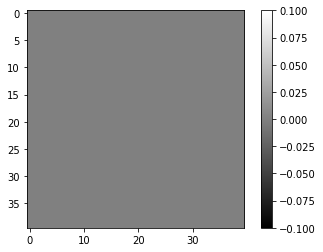

1


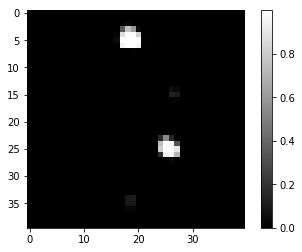

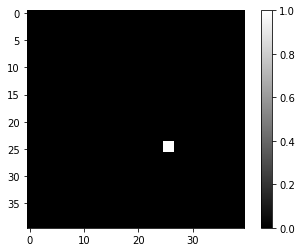

2


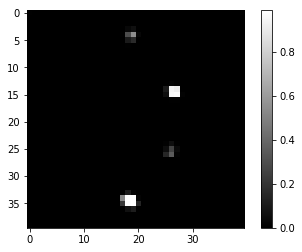

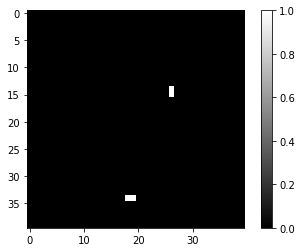

3


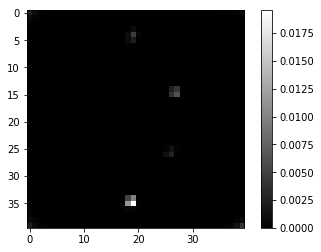

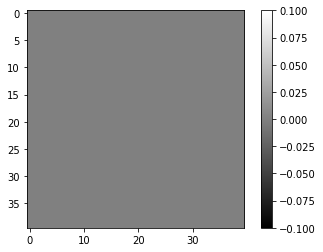

weights
0


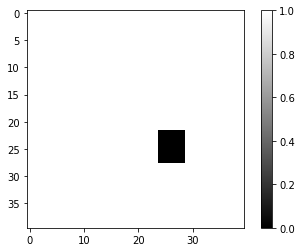

1


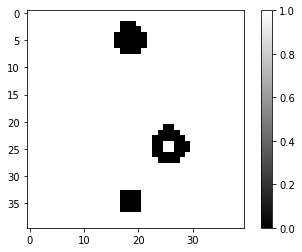

2


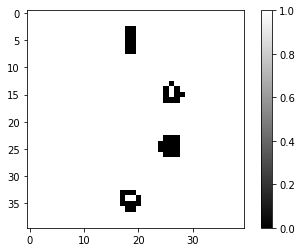

3


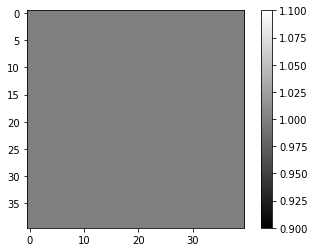

In [11]:
lab = gt_labels.reshape((H,W,K))
weights = gt_weights.reshape((H,W,K))

plt.figure()
plt.imshow(x[0,:,:,0])
plt.show()

for i in range(K):
    print(i)
    plt.figure()
    plt.imshow(out_obj[0,:,:,i], cmap='gray')
    plt.colorbar()
    plt.show()
    
    plt.figure()
    plt.imshow(lab[:,:,i], cmap='gray')
    plt.colorbar()
    plt.show()
    
print("weights")
for i in range(K):
    print(i)
    plt.figure()
    plt.imshow(weights[:,:,i], cmap='gray')
    plt.colorbar()
    plt.show()

In [12]:
predicted_boxes, predicted_obj = sess.run([list_box, list_obj],{x_tf:x})

In [13]:
anch_p = anchors.reshape((-1,4))[predicted_obj>0.9]

In [14]:
bp = predicted_boxes[predicted_obj>0.9]

In [15]:
gt_p = gt_t[predicted_obj>0.9]

In [16]:
bp_n = box.inv_bbox_transform(anch_p, bp)
gt_n = box.inv_bbox_transform(anch_p, gt_p)
print(bp_n*H)
print(gt_n*H)
print(gt_box*H)

[[18.09318456  4.52506191  6.01459551  7.6379447 ]
 [18.47008499  4.52619249  6.28885031  7.65021706]
 [17.92435246  4.6928115   6.31356382  7.56313229]
 [17.84377977  4.54091407  6.25420189  8.17928886]
 [18.11900374  4.59395058  6.44191599  8.09477615]
 [18.65157965  4.8694315   6.72859192  7.59372997]
 [18.02879825  4.59834124  6.94148207  7.37658167]
 [17.90136769  4.73316933  6.8521843   8.32885838]
 [18.18233654  5.00682331  7.01467848  8.07691002]
 [18.36829141  5.27763558  7.30890322  6.78281116]
 [27.11842323 15.53457858  5.10407448  5.35612392]
 [27.33895732 15.69756331  5.20107794  5.32462978]
 [27.18342612 15.70765256  4.95021152  5.25780153]
 [27.46364806 15.75886225  5.09389782  5.30065298]
 [25.37611488 25.30573175  6.68527222  6.73342466]
 [25.87772105 25.11225546  6.76427126  6.87469482]
 [25.3252695  25.24943454  6.9073143   7.10901117]
 [25.67681907 25.16175488  6.93565607  7.29655743]
 [26.08814977 25.41097245  6.93934298  6.98473692]
 [25.4726079  25.59869663  6.96

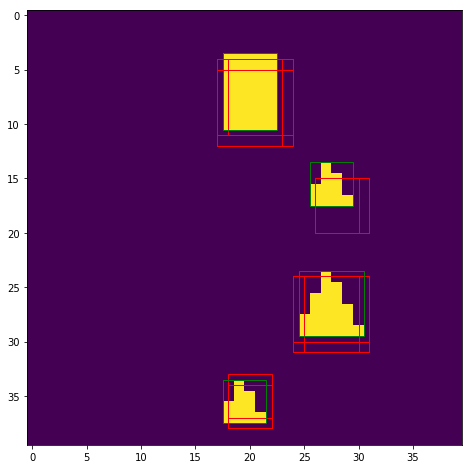

In [17]:
# Create figure and axes
fig,ax = plt.subplots(1, figsize=(8,8))

# Display the image
ax.imshow(x[0,:,:,0])

# Create a Rectangle patch
for b in bp_n:
    rect = patches.Rectangle((int(b[0]*w),int(b[1]*h)),int(b[2]*H),int(b[3]*H),linewidth=1,
                             edgecolor='r',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    # Create a Rectangle patch
for b in gt_box:
    rect = patches.Rectangle((int(b[0]*w)-0.5,int(b[1]*h)-0.5),int(b[2]*H),int(b[3]*H),linewidth=1,
                             edgecolor='g',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
    
plt.show()

In [18]:
cropped = sess.run(crop_conv,{x_tf:x})

In [19]:
print(cropped.shape)

(25, 30, 30, 1)


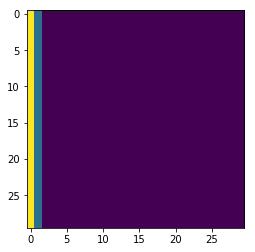

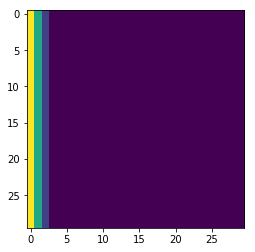

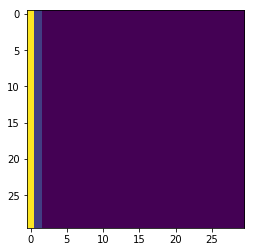

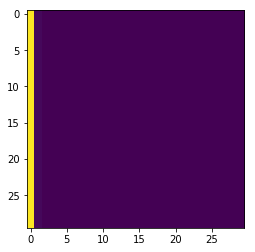

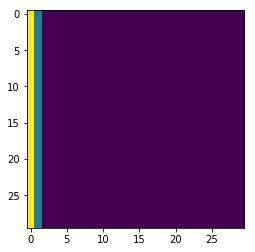

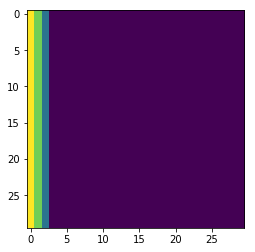

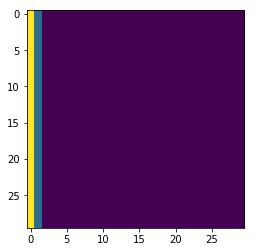

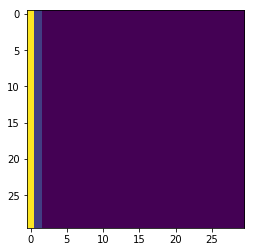

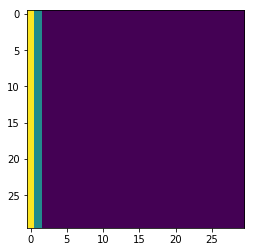

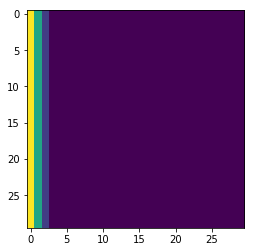

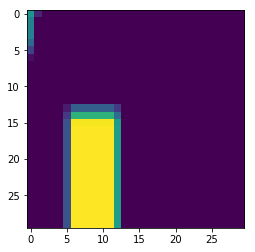

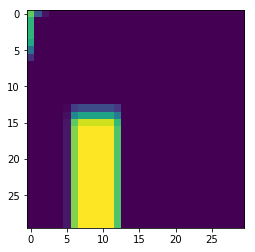

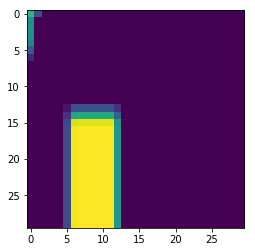

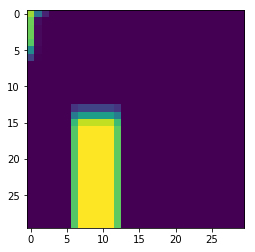

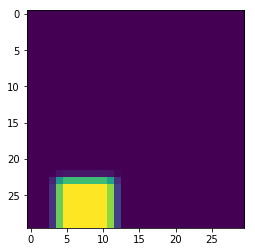

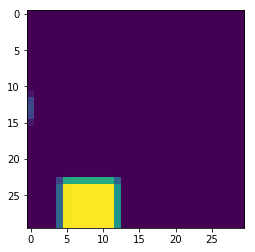

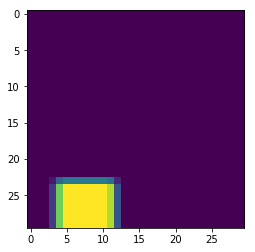

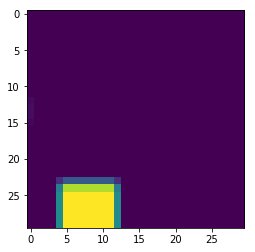

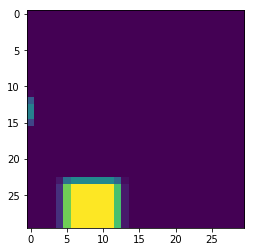

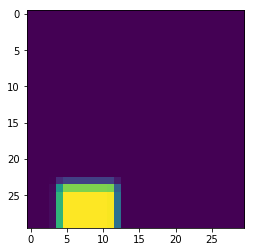

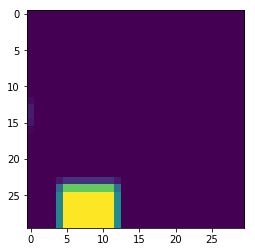

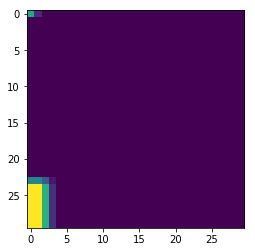

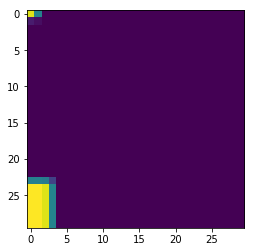

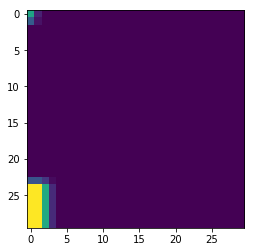

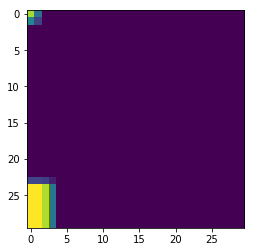

In [20]:
for n in range(cropped.shape[0]):
    plt.figure()
    plt.imshow(cropped[n,:,:,0])
    plt.show()

In [21]:
real_box = sess.run(sel_real_box,{x_tf:x})
print(real_box*H)
print(print(bp_n*H))

[[18.093184   4.5250616  6.0145955  7.6379447]
 [18.470085   4.5261927  6.2888503  7.6502175]
 [17.924353   4.6928115  6.3135643  7.563133 ]
 [17.843779   4.5409145  6.254202   8.179289 ]
 [18.119003   4.5939507  6.4419165  8.094776 ]
 [18.65158    4.869432   6.728592   7.59373  ]
 [18.028797   4.5983415  6.9414825  7.376582 ]
 [17.901367   4.7331696  6.8521843  8.328858 ]
 [18.182337   5.0068235  7.014679   8.07691  ]
 [18.368294   5.277636   7.308903   6.782811 ]
 [27.118423  15.534578   5.1040745  5.356124 ]
 [27.338959  15.697564   5.201078   5.3246303]
 [27.183428  15.707653   4.9502115  5.2578015]
 [27.463648  15.7588625  5.0938983  5.300653 ]
 [25.376114  25.305733   6.685272   6.7334247]
 [25.877722  25.112257   6.7642713  6.874695 ]
 [25.32527   25.249435   6.907315   7.1090117]
 [25.67682   25.161755   6.935656   7.2965574]
 [26.08815   25.410975   6.9393435  6.984737 ]
 [25.472607  25.598698   6.9635324  7.300274 ]
 [25.719055  25.640705   6.9079638  7.3503494]
 [19.096024  